In [1]:
import numpy as np

import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.primitives import StatevectorSampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit.visualization import plot_histogram

from qiskit_ibm_runtime import QiskitRuntimeService, Batch, SamplerV2 as Sampler

## 1) Preparation

### 1.1) Parametrization

In [2]:
n_circuits = 9
batch_size = 3 # Must be a factor of n_circuits

shots = 1024

optimization_level = 0

token = ""
channel = "ibm_quantum"
instance = "ibm-q/open/main"

### 1.2) Define multiple quantum circuits

In [3]:
def build_qc(n_qubits):
    
    qr = QuantumRegister(n_qubits, "q")
    cr = ClassicalRegister(n_qubits, "c")
    
    qc = QuantumCircuit(qr, cr)
    
    qc.h(0)
    for i in range(n_qubits-1):
        qc.cx(i, i+1)

    qc.barrier()
    
    for i in range(n_qubits):
        qc.measure(i, i)

    return qc

In [4]:
qc_list = []

for i in range(n_circuits):
    qc_list.append(build_qc(i+2))

### 1.3) Prepare multiple ISA circuits

In [5]:
service = QiskitRuntimeService(channel=channel, instance=instance)
backend = service.least_busy(operational=True, min_num_qubits=n_circuits+2)

print(
    f"Name: {backend.name}\n"
    f"Version: {backend.version}\n"
    f"Qubits: {backend.num_qubits}\n"
)

Name: ibm_sherbrooke
Version: 2
Qubits: 127



In [6]:
target = backend.target

pm = generate_preset_pass_manager(target=target, optimization_level=optimization_level)

In [7]:
isa_list = []

for qc in qc_list:
    isa_list.append(pm.run(qc))

## 2) Running all the circuits in one batch

### 2.1) Separate the circuits into batches

In [8]:
batches = [isa_list[(i*batch_size):((i+1)*batch_size)] for i in range(n_circuits//batch_size)]

### 2.2) Run the batches

In [9]:
job_ids = []

with Batch(backend=backend, max_time="60s"):
    
    sampler = Sampler()

    for batch in batches:
        job = sampler.run(batch, shots=shots)
        job_id = job.job_id()
        print("Job ID: ", job_id)
        job_ids.append(job_id)

Job ID:  cyt8phajj6dg008fz9p0
Job ID:  cyt8phtq5bwg0083h4vg
Job ID:  cyt8pja38jq0008xs0e0


## 3) Postprocessing

### 3.1) Retrieving the job from the ID

In [10]:
job_list = [service.job(job_id) for job_id in job_ids]

### 3.2) Post-processing the results

In [11]:
def get_hist(job_index, index):

    result = job_list[job_index].result()

    try:
        counts = result[index].data.c.array
    except:
        counts = result[index]["__value__"]["data"]["c"].array
    
    hist = {}
    
    for i in range(len(counts)):
    
        x_binary = "".join([bin(counts[i][j])[2:] for j in range(len(counts[i]))]).zfill(job_index*batch_size+index+2)
    
        hist[x_binary] = hist.get(x_binary, 0) + 1
    
    return hist

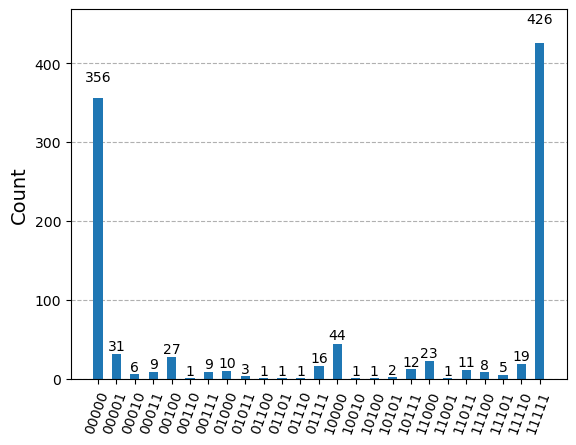

In [12]:
job_index = 1
index = 0

hist = get_hist(job_index, index)
plot_histogram(hist)